# WSB Topic Modelling

From the mess that we've experienced in the financial markets in February 2020 due to the Redditers horde, I've got curious about the whys and hows this event happen.

In this notebook, I'll try to satisfy my curiosity by trying to find what are the main topics in the body of the wallstreetbets posts.

In [ ]:
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy


%matplotlib inline

In [ ]:
dataset_path = '../input/reddit-wallstreetsbets-posts/reddit_wsb.csv'
data = pd.read_csv(dataset_path)

data

First of all, let's all the columns of the dataframe that have empty body.

In [ ]:
data.dropna(subset=['body'], inplace=True)

In [ ]:
data['original_body'] = data['body']

In [ ]:
data.shape

# Text Cleaning & Preprocessing

One of the most crucial phases when dealing with unstructured data such as text is the cleaning/preprocessing step. Sometimes this process is even more important than the model-building part.

Since both the methodologies that I'll use to find the topics in wsb posts are simple models, it is better to remove words that don't carry much information about the post itself such as punctuation, stop words, and others...

In this section of the kernel, I'm going to clean the `body` of the DataFrame preparing it for the successive phases.

The cleaning steps that I'm going to apply are:
- Removal of URLs
- Removal of punctuation
- Removal of emojis
- Lower casing
- Removal of stopwords
- Lemmatization
- Removal of other non-meaningful characters

In [ ]:
nlp = spacy.blank('en')

In [ ]:
import re

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [ ]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [ ]:
def remove_stop_words(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])

In [ ]:
def lemmatize_words(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [ ]:
remove_spaces = lambda x : re.sub('\\s+', ' ', x)

In [ ]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [ ]:
remove_double_quotes = lambda x : x.replace('"', '')
remove_single_quotes = lambda x : x.replace('\'', '')
trim = lambda x : x.strip()

In [ ]:
other_chars = ['*', '#', '&x200B', '[', ']', '; ',' ;' "&nbsp", "“","“","”", "x200b"]
def remove_other_chars(x: str):
    for char in other_chars:
        x = x.replace(char, '')
    
    return x

In [ ]:
def lower_case_text(text):
    return text.lower()

In [ ]:
funcs = [
    remove_urls, 
    remove_punctuation,
    remove_stop_words, 
    remove_emoji, 
    remove_double_quotes, 
    remove_single_quotes,
    lower_case_text,
    remove_other_chars,
    lemmatize_words,
    remove_spaces,
    trim]

for fun in funcs:
    data['body'] = data['body'].apply(fun)

In [ ]:
# reset indexes (again)
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)

data

In [ ]:
''.join(char for char in data.body.loc[4] if char in string.printable)

In [ ]:
body_list = data.body.tolist()

In [ ]:
body_list[0]

# EDA

Before we go straight to the model build phase, let's see how's the data look like, just to have an overview.

## Most frequent ngrams

Now that most of the meaningless words have been removed, let's see which are the most frequent unigrams.

In [ ]:
from collections import Counter 

counter = Counter()

for body in body_list:
    doc = nlp(body)
    counter.update([token.text for token in doc])

In [ ]:
most_common_unigrams = counter.most_common()[0:30]
words = [item[0] for item in most_common_unigrams]
freq = [item[1] for item in most_common_unigrams]

In [ ]:
plt.figure(figsize=(8, 25))
sns.barplot(y=words, x=freq, color='red')

As you might guess in the top 3 we have the name of the stock that made r/wsb famous, we are talking about `GME`!

Whereas if you look further in the top 40 you might encounter words like: stock, market, sell, share, trading, ... which are all words related to the financial world.

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
fig_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='lightgrey', 
                          colormap='viridis', width=800, height=600
                         ).generate(' '.join(body_list))

plt.figure(figsize=(10, 7), frameon=True)
plt.imshow(fig_wordcloud)
plt.axis('off')
plt.show()

Let's now see what are the most common **bigrams** and **trigrams** in the dataset.

In [ ]:
def generate_ngrams(text, n_gram=2):
    token = [token for token in text.lower().split(' ') if token != '']
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [ ]:
bigram_counter = Counter()

for body in body_list:
    bigram_counter.update(generate_ngrams(body, 2))

In [ ]:
most_common_bigrams = bigram_counter.most_common()[0:30]
bigrams = [item[0] for item in most_common_bigrams]
bi_freq = [item[1] for item in most_common_bigrams]

In [ ]:
plt.figure(figsize=(8, 25))
sns.barplot(y=bigrams, x=bi_freq, color='green')

In [ ]:
trigram_counter = Counter()

for body in body_list:
    trigram_counter.update(generate_ngrams(body, 3))

In [ ]:
most_common_trigrams = trigram_counter.most_common()[0:30]
trigrams = [item[0] for item in most_common_trigrams]
tri_freq = [item[1] for item in most_common_trigrams]

In [ ]:
plt.figure(figsize=(8, 25))
sns.barplot(y=trigrams, x=tri_freq, color='blue')

# Topic Modelling using SVD

A common technique for find topics in text data is through matrix decomposition. Matrices decomposition are factorizations that "decompose" a matrix into a product of simpler matrices. This factorization can be exact (the product of the simpler matrices gives back the original matrix) or not exact (the product of the simpler matrices gives back something similar to the matrix). 

Matrices decompositions are discovered to be useful in topic modeling because the simpler matrices capture some kind of hidden relationship between the documents and the words.  

Instead of using a **term-document** matrix (which is a mathematical matrix that describes the frequency of terms that occur in a collection of documents), we will use 
[Topic Frequency-Inverse Document Frequency](http://www.tfidf.com/) (TF-IDF) as a way to normalize term counts by taking into account how often they appear in a document, how long the document is, and how common/rare the term is.

We'll decompose the tf-idf matrix using a famous matrix decomposition called the Singular Value Decomposition (SVD). If you know a little about linear algebra, you can see the SVD decomposition as a generalization of the eigen decomposition for non square matrices. 

The result of the SVD decomposition are three matrices as shown here:

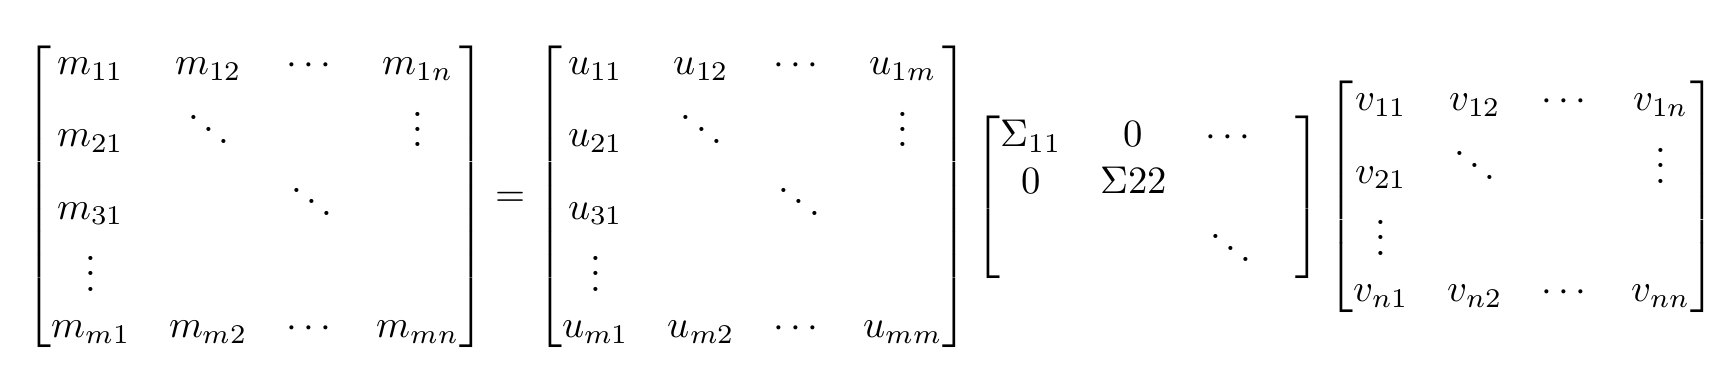

In our case the first matrix $U$ is called the ***document-to-topic*** matrix, it is a $document \times topic$ matrix, and it captures the probabilities of topics for each document.

The $\Sigma$ matrix is a non-negative square matrix is called ***topic-to-topic*** matrix, with $topic \times topic$ dimension and it captures the importance of each topic.

While the last matrix, the $V$ matrix is called the ***topic-to-word*** matrix, and this last matrix captures the probabilities that each word appears in a topic.

The values in the decomposed matrices don't have to be interpreted as probabilities, because they can be negative, but despite that, I think that gives a better idea of the meaning of these matrices.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import linalg
from sklearn import decomposition
import fbpca

number_of_topics = 10
num_top_words = 8
vectorizer = TfidfVectorizer()

In [ ]:
vectors = vectorizer.fit_transform(body_list).todense()
vocab = np.array(vectorizer.get_feature_names())

In [ ]:
vectors.shape, vocab.shape

In [ ]:
def show_topics(a, vocab, ngram=False):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    if not ngram:
        return [' '.join(t) for t in topic_words]
    else:
        return [' - '.join(t) for t in topic_words]

In [ ]:
u, s, v = fbpca.pca(vectors, number_of_topics)

In [ ]:
show_topics(v[:10], vocab)

The topics are obtained by taking the words with highest "probability" form the matrix `v` (the **topic-to-words** matrix).  

Those are the topics that we've got from the matrix decomposion. As we can see most of them contains at least one the most talked stocks in the subreddit such as GME, AMC, NOK, BB, ... but also words such as holding, moon, buy, stock are appear in the topics. 

Now let's see if the found topics represents, or at least try to do it, the body of the wsb posts.

In [ ]:
show_topics(v[:10], vocab)[np.argmax(u[107])]

In [ ]:
data.original_body.loc[107]

The topics assigned to post **107** kinda match what the post is expressing because both **AMC** and **GME** are present in the text.

In [ ]:
show_topics(v[:10], vocab)[np.argmax(u[2179])]

In [ ]:
data.original_body.loc[2179]

While in the topics assigned to post **2179** is also making sense: both **NOK** and **AMC** appear in the topic.

## Bigrams matrix

Instead of decomposing only the **term-document** matrix, let's now try to apply the **SVD** decomposition to the **bigram-document** matrix just to see what the outcomes look like.

In [ ]:
bigram_vectorizer = TfidfVectorizer(ngram_range=(2,2))

In [ ]:
bigrams_vectors = bigram_vectorizer.fit_transform(body_list).todense()
bigrams_vocab = np.array(bigram_vectorizer.get_feature_names())

In [ ]:
u1, s1, v1 = fbpca.pca(bigrams_vectors, number_of_topics)

In [ ]:
show_topics(v1[:10], bigrams_vocab, ngram=True)

As we can see the topics that we've obtained from the decomposition of the bigram matrix are way more interpretable compared to the topic that we've obtained from the unigram matrix decomposition. For instance the first topic might be related to the weekly thread posting since it contains bigrams such as *best daily*, *discussion thread*, and so on ... While are a few topic that contains the bigram *f#ck robinhood*, those topic might be related to negative comments on the broker robinhood.

In [ ]:
show_topics(v1[:10], bigrams_vocab, ngram=True)[np.argmax(u1[280])]

In [ ]:
data.original_body.loc[280]

Here the topic should be about a negative review on Robinhood, but the assigned topic haven't any words related to Robinhood or negativity. I think that topic 8 (or 9) should be more appropriate in this case.

In [ ]:
del v1, u1, s1, bigrams_vectors, bigrams_vocab

# Topic Modelling with LDA

Another method used for finding topics in documents is the [**Latent Dirichlet Allocation**](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (**LDA**). LDA is a generative statistical model where documents are represented as a mixture of topics and a topic is a bunch of words. Those topics reside within a hidden, also known as a latent layer. 

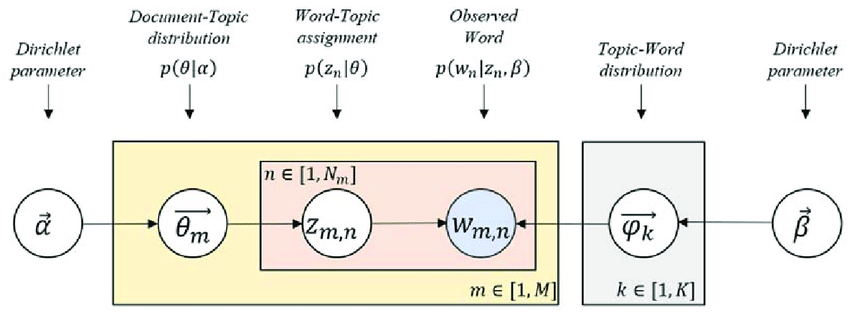

LDA looks at a document to determine a set of topics that are likely to have generated that collection of words. So, if a document uses certain words that are contained in a topic, you could say the document is about that topic. 

To build out LDA model we are going to use a fantastic library for topic modelling: [Gensim](https://radimrehurek.com/gensim/intro.html)! But before to build and train we to to build a dictionary of the vocabulary the the model is going to use. A dictionary in NLP is simply a mapping between words and their integer ids.

In [ ]:
docs = [body.split() for body in body_list]

In [ ]:
from gensim.corpora import Dictionary

dic = Dictionary(docs)

In [ ]:
corpus = [dic.doc2bow(doc) for doc in docs]

## Training 

Now it's time to train our topic model. We do this with the following parameters:

- **corpus**: the bag-of-word representations of our documents
- **id2token**: the mapping from indices to words
- **num_topics**: the number of topics we want the model to identify
- **chunksize**: the number of documents the model sees for every update
- **passes**: the number of times we show the total corpus to the model during training
- **random_state**: we use a seed to ensure reproducibility.

In [ ]:
from gensim.models import LdaModel

model = LdaModel(corpus=corpus, id2word=dic, num_topics=number_of_topics, chunksize=2500, passes=5, random_state=1)

Now that our model is trained, let's output the topics that he has learnt. For each topic we'll print the 10 most significant words, hence mathematically speaking the words with the highest probability to appear in the topic. This is showing some interesting patterns already: **topic 9** will likely related to daily trading discussion thread; **topic 5** and **topic 4** will be related to markets, stocks, options, and everything realted to finance; **topic 10** seems linked to cannabis and marijuana since tickers related to the latter appears in the topic.

In [ ]:
for (topic, words) in model.print_topics():
    print(topic+1, ":", words, '\n\n')

Finally, let's inspect the topics the model recognizes in some of the individual documents. Here we see how LDA tends to assign a high probability to a low number of topics for each document, which makes its results very interpretable.

In [ ]:
original_body_list = data.original_body.tolist()

In [ ]:
for (text, doc) in zip(original_body_list[:9], docs[:9]):
    print('\033[1m' + 'Text: ' + '\033[0m', text)
    print('\033[1m' + 'Topics: ' + '\033[0m', [(topic+1, prob) for (topic, prob) in model[dic.doc2bow(doc)] if prob > 0.15])
    print('\n')

Now let's see what topic is going to assign to the post-**2179**, previously tested with the svd decomposition for the unigram term-document matrix.

In [ ]:
print('\033[1m' + 'Text: ' + '\033[0m', original_body_list[2179])
print('\033[1m' + 'Topic: ' + '\033[0m', [(topic+1, prob) for (topic, prob) in model[dic.doc2bow(docs[2179])] if prob > 0.1])

the topics assigned by the LDA are not 100% spot-on, **topic 5** seems to be appropriate but **topic 9** seems to be out of place.

Let's see what kind of topic the LDA is going to choose for the post **280** tested with the bigram matrix decomposition.

In [ ]:
print('\033[1m' + 'Text: ' + '\033[0m', original_body_list[107])
print('\033[1m' + 'Topic: ' + '\033[0m',[(topic+1, prob) for (topic, prob) in model[dic.doc2bow(docs[107])] if prob > 0.1])

While also in this case **topic 4** and **topic 5** are quite right, **topic 9** I think is out of place since this post isn't a daily trading discussion.

# Conclusion 

Finding patterns and understanding the hidden structure of data is a complicated task. Especially when we are dealing with messy and unstructured data as text. Topic models such as Latent Dirichlet Allocation or matrices decomposition are useful techniques to discover the most prominent topics in such documents. While these results are often very revealing already, it's also possible to use them as a starting point, for example for a labeling exercise for supervised text classification. Although traditional topic models are lacking in more semantic information (they don't use word embeddings, for instance), they should be in every NLPer's toolkit as a really quick way of getting insights into large collections of documents.

# References

- [Getting Started with Text Preprocessing](https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing/comments#1272867)
- [Fast.ai NLP Course Topic Modelling Lesson 2](https://www.youtube.com/watch?v=tG3pUwmGjsc&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=2&t=2s)
- [Fast.ai NLP Course Topic Modelling Lesson 3](https://www.youtube.com/watch?v=lRZ4aMaXPBI&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=3)
- [NLP with Disaster Tweets by gunes evitan](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert#3.-Target-and-N-grams)
- [Discovering and Visualizing Topics in Texts with LDA](https://github.com/nlptown/nlp-notebooks/blob/master/Discovering%20and%20Visualizing%20Topics%20in%20Texts%20with%20LDA.ipynb)